# DCGAN CelebA

This notebook is for implementing `Deep Convolution Generative Adversarial Network(DCGAN)` from the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) with [Tensorflow](https://www.tensorflow.org). <br>
[CelebA dataset](https://www.kaggle.com/jessicali9530/celeba-dataset), which is 128x128 size, will be used. 

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import glob
import cv2 

## Parameters


In [3]:
img_size   = 128

batch_size = 128
num_epoch  = 5

n_latent = 100

beta1 = 0.5

learning_rate_g = 0.0002
learning_rate_d = 0.0002

show_result_step = 50

gpu_fraction = 0.5 

## Import CelebA Dataset

Get names of the files in the celeba dataset folder.

In [4]:
celebA_list = glob.glob('../../hyeonseop/Dataset/Celeba/img_align_celeba_png/*.png')

print("CelebA dataset Length: {}".format(len(celebA_list)))

CelebA dataset Length: 202599


## Generator

In [5]:
def Generator(x, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        # Project and Reshape 
        w1 = tf.get_variable('w1', [x.get_shape()[1], 8*8*1024], initializer=xavier_init)
        b1 = tf.get_variable('b1', [8*8*1024], initializer=xavier_init)
        
        x_project = tf.matmul(x,w1)+b1
        x_reshape = tf.reshape(x_project, (-1, 8, 8, 1024))
        
        # First deconv layer (output_shape =16x16)
        h1 = tf.layers.conv2d_transpose(x_reshape,filters=512, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second deconv layer (output_shape = 32x32)
        h2 = tf.layers.conv2d_transpose(h1,filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)  
        
        # Third deconv layer (output_shape = 64x64) 
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer (output_shape = 128x128)
        logits = tf.layers.conv2d_transpose(h3, filters=3, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)     
        output = tf.tanh(logits)
                
        return output

## Discriminator

In [6]:
def Discriminator(x, is_trainint, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()

        # First conv layer
        h1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)
        
        # Trhid conv layer
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        flatten = tf.reshape(h3, (-1, h3.get_shape()[1]*h3.get_shape()[2]*h3.get_shape()[3]))
        
        logit  = tf.layers.dense(flatten, 1, kernel_initializer=xavier_init)
        output = tf.sigmoid(logit)  

        return logit, output

## GAN

In [7]:
def GAN(x, z, is_training):
    # Generator
    G = Generator(z, is_training)
    
    # Discriminator
    D_logit_real, D_out_real = Discriminator(x, is_training)
    D_logit_fake, D_out_fake = Discriminator(G, is_training, reuse=True)    
   
    # get loss
    d_loss = -(tf.reduce_mean(tf.log(D_out_real + 1e-8)) + tf.reduce_mean(tf.log( (1-D_out_fake) + 1e-8)))
    g_loss = -tf.reduce_mean(tf.log(D_out_fake + 1e-8))

    return d_loss, g_loss , G, D_out_real, D_out_fake

## Build Graph

In [8]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
x_normalize = (tf.cast(x, tf.float32) - (255.0/2)) / (255.0/2)

z = tf.placeholder(tf.float32, shape=[None, n_latent])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G, D_out_real, D_out_fake = GAN(x_normalize, z, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(learning_rate_d, beta1=beta1).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(learning_rate_g, beta1=beta1).minimize(g_loss, var_list=trainable_variables_g)

## Initialization

In [9]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Train

In [ ]:
# Training
len_data = len(celebA_list)

count_step = 0 

for i in range(num_epoch):
    # Shuffle the data 
    np.random.shuffle(celebA_list)
        
    # Making mini-batch
    for j in range(0, len_data, batch_size): 
        if j + batch_size < len_data:
            data_x_in = np.zeros([batch_size, img_size, img_size, 3])
        
            for k in range(batch_size):
                img_temp = cv2.imread(celebA_list[j + k])
                data_x_in[k,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]
        else:
            data_x_in = np.zeros([len_data - j, img_size, img_size, 3])
        
            for k in range(len_data - j):
                img_temp = cv2.imread(celebA_list[j + k])
                data_x_in[k,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]
               
        sampled_z = np.random.uniform(-1, 1, size=(data_x_in.shape[0] , n_latent))
        
        # Run Optimizer!
        _, loss_d = sess.run([train_step_d, d_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})
        _, loss_g = sess.run([train_step_g, g_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})
        
        if count_step % show_result_step == 0:
            # Print Progess
            print("Epoch: {} / Batch: {:.3f}% / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), (j/len_data), loss_g, loss_d))
            
            # Show test images 
            z_test = np.random.uniform(-1, 1, size=(5, n_latent))
            G_out = sess.run(G, feed_dict = {z: z_test, is_training: False})
            G_out = (G_out + 1.0)/2
            
            f, ax = plt.subplots(1,5, figsize=(15,15))
            for j in range(5):
                img_RGB = cv2.cvtColor(G_out[j,:,:,:], cv2.COLOR_BGR2RGB)
                ax[j].imshow(img_RGB)
                ax[j].axis('off')
                ax[j].set_title('Image '+str(j))

            plt.show()
            
            count_step = 0
        
        count_step += 1

## Image Generation

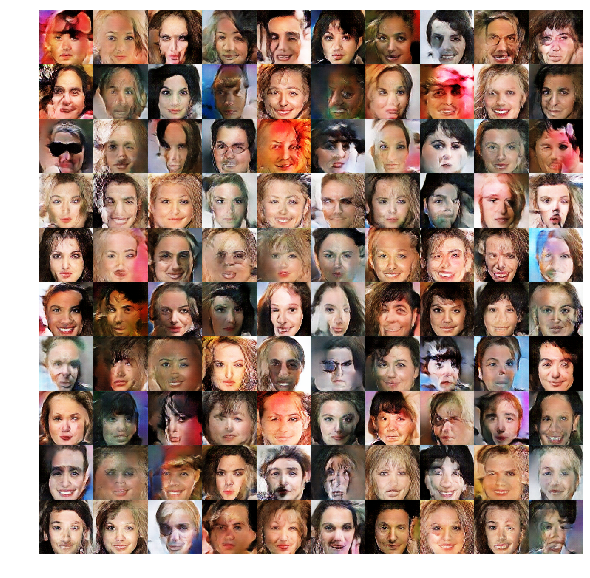

In [11]:
num_test = 10

img = np.zeros([img_size * num_test, img_size * num_test, 3])

z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
G_result = sess.run(G, feed_dict = {z: z_result, is_training: False})
G_result = (G_result + 1.0)/2

for i in range(num_test**2):
    row_num = int(i/num_test)
    col_num = int(i%num_test)
    
    img_RGB = cv2.cvtColor(G_result[i,:,:,:], cv2.COLOR_BGR2RGB)
    img[row_num * img_size : (row_num + 1) * img_size, (col_num) * img_size : (col_num + 1) * img_size] = img_RGB

plt.figure(figsize=(10,10))

plt.imshow(img)
plt.axis('off')
plt.show()